# Neurology Data

Data were acquired from EBRAINS (https://www.ebrains.eu/).

- The multi-grasp electrode dataset: https://gin.g-node.org/INT/multielectrode_grasp, https://doi.gin.g-node.org/10.12751/g-node.f83565/
- Data paper on the data: https://www.nature.com/articles/sdata201855
- Paper using the data: https://www.frontiersin.org/articles/10.3389/fncir.2013.00048/full

Following the README I am using the `no_raw.nix` versions of the data which should be both more light weight and appropriate for analysis without any further processing. These data has been low-pass filtered to exclude the very high-frequency component of the signal.

The provided data were quality controlled and are only provided for demonstrative purposes.

## References

1. Riehle, A., Wirtssohn, S., Gruen, S. & Brochier, T. Mapping the spatio-temporal structure of motor cortical LFP and spiking activities during reach-to-grasp movements. Front. Neural Circuits 7, (2013).
2. Brochier, T. et al. Massively parallel recordings in macaque motor cortex during an instructed delayed reach-to-grasp task. Sci Data 5, 180055 (2018).


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import xarray as xr
from matplotlib import gridspec, transforms
import copy
from scipy import signal
from matplotlib.colors import ListedColormap

from pydmd.mrcosts import mrCOSTS
import warnings
import glob

from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import matplotlib.dates as md
import matplotlib

warnings.filterwarnings("ignore")

# Get the path of the notebook. Re-running this cell will break the logic used.
dir_notebook = os.getcwd()

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = "paper"
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    "#4477AA",
    "#CCBB44",
    "#EE6677",
    "#228833",
    "#66CCEE",
    "#AA3377",
    "#BBBBBB",
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

alphabet = string.ascii_lowercase

## Directories

These should be amended to point towards where you have the data (`dir_hadisst_data`), where you want the figures to go (`dir_print`), and where the mrCOSTS fits are stored (`dir_results`). You will need to run the notebook and fit mrCOSTS in order to generate the fitted model.

In [3]:
dir_neurology_data = os.path.join(dir_notebook, "data/neurology")
dir_print = os.path.join(dir_notebook, "figures/neurology")
dir_results = os.path.join(dir_notebook, "results/neurology")

# Load data

I have provided a quality control version of Monkey "L" or "Lilou" for Trial 2. Please refer to the above citations for the actual data. These data were simply cut out for ease of sharing the notebook for demonstrative purposes.

In [4]:
os.chdir(dir_neurology_data)
ds_obs = xr.load_dataset("utah-array_Monkey-L_trial-2.nc", engine="h5netcdf", invalid_netcdf=True)

## Validating the data quality

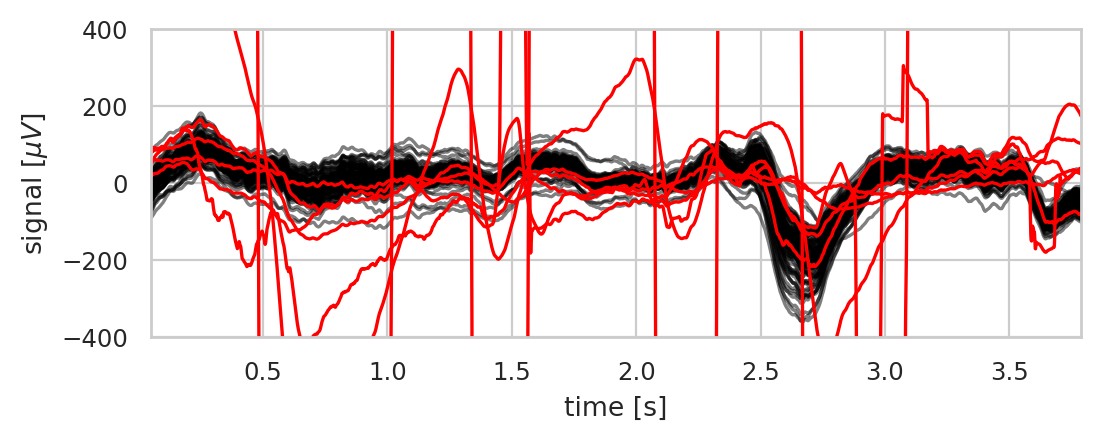

In [5]:
plt.figure(figsize=(6, 2))

# Select just the points that pass the QC and plot them in black.
ds_obs_qc = ds_obs.where(ds_obs.qc_mask == False, drop=True)
# We perform a rolling average for visual clarity.
ds_obs_qc.signal.rolling(time=100, center=True).mean().plot.line(
    alpha=0.5, color="k", x="time", add_legend=False
)

# Select just the points that do not pass the QC and plot them in red.
ds_obs_bad = ds_obs.where(ds_obs.qc_mask == True, drop=True)
# We perform a rolling average for visual clarity.
ds_obs_bad.signal.rolling(time=100, center=True).mean().plot.line(
    x="time", color="r", add_legend=False
)

plt.ylim(-400, 400)
plt.xlim(ds_obs.time[50].values, ds_obs.time[-50].values);

The QC successfully identified points that were wildly irregular relative to the behavior of the rest of the array in red.

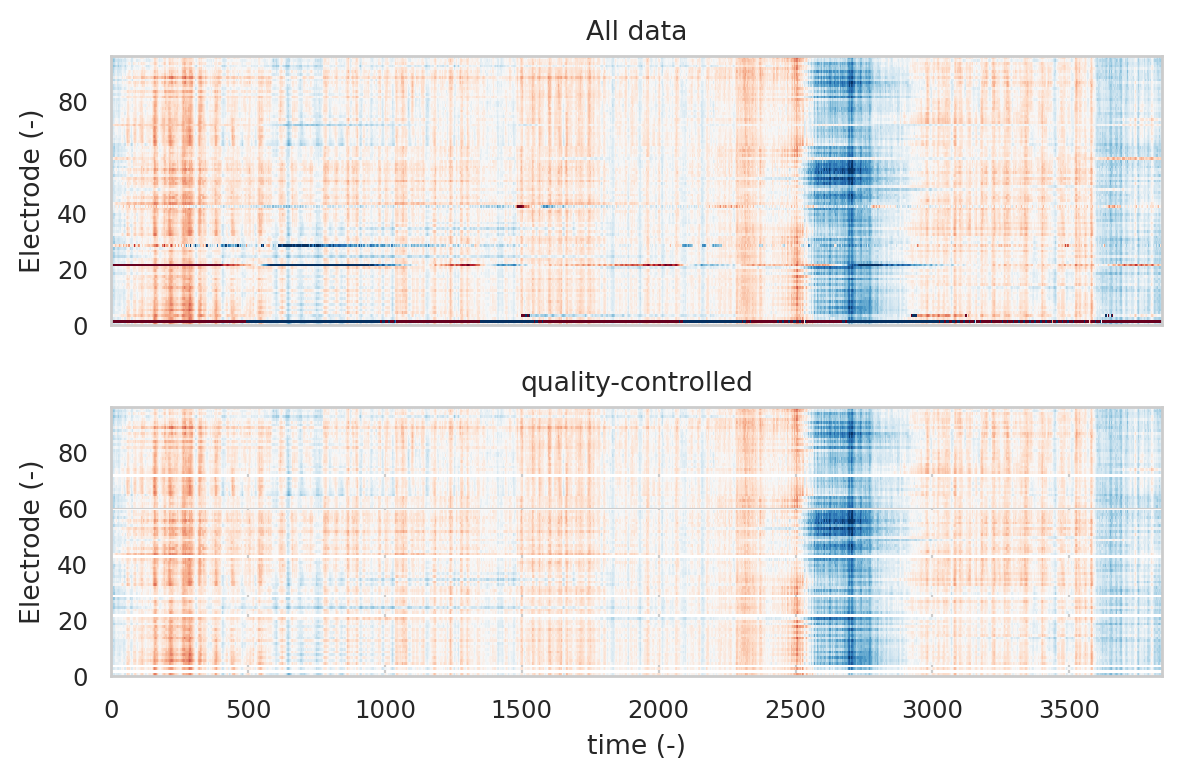

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax = axes[0]
ax.pcolormesh(ds_obs.signal.values.T, vmin=-400, vmax=400, cmap="RdBu_r")
ax.set_title("All data")
ax.set_ylabel("Electrode (-)")

ax = axes[1]
ax.pcolormesh(
    ds_obs.signal.where(ds_obs.qc_mask == False).values.T,
    vmin=-400,
    vmax=400,
    cmap="RdBu_r",
)
ax.set_title("quality-controlled")
ax.set_ylabel("Electrode (-)")
ax.set_xlabel("time (-)")

fig.tight_layout()

We've identified points that are "streaky" meaning they don't covary with the other data points.

## Finish the data preparation

In [7]:
data_to_fit = ds_obs.where(ds_obs.qc_mask == False, drop=True).signal.values

# Time in seconds
ts = ds_obs.time.values

# Time step in seconds
dt = 0.001

# Fit mrCOSTS

## Hyperparameters

In [8]:
# Window size (in time steps)
window_lengths = np.array([50, 100, 250, 500, 1000, 2000])
# Step size between windows (in time steps). 10% of the window width is usually sufficient.
step_sizes = np.array([5, 10, 25, 50, 100, 200])
# Rank of each decomposition levels fit.
svd_ranks = [8] * len(window_lengths)
# How many decomposition levels were performed.
num_decompositions = len(window_lengths)
# Whether to use a global svd when fitting each window.
global_svd_array = [False] * len(window_lengths)
# Other kwargs to pass to the bopdmd object.
pydmd_kwargs = None
# This specifies that we should find the number of bands for each local decomposition level
# instead of providing the number a priori.
cluster_sweep = True

# The name to give the model fit.
monkey = "Lilou"
trial_id = "2"
strategy = "svd-rank-{}".format(svd_ranks[0])
data_name = f"neuro-{monkey}_trial-{trial_id}_qc"


# Set this flag to True to fit the object. Once fitted, set it to False to use the previously fitted model.
fit = False

Note that if you fit with a version of PyDMD newer than 1.0, you will need to provide a few additional keywords in order to get similar results as in the PNAS paper.

- `relative_filter_length = 8`
- `kern_method = "kern"`

In [9]:
if fit:
    mrc = mrCOSTS(
        svd_rank_array=svd_ranks,
        window_length_array=window_lengths,
        step_size_array=step_sizes,
        global_svd_array=global_svd_array,
        cluster_sweep=cluster_sweep,
        transform_method="absolute",
        pydmd_kwargs=pydmd_kwargs,
    )

    mrc.fit(data_to_fit, np.atleast_2d(ts))

## I/O

In [11]:
os.chdir(dir_results)
filename = ".".join([data_name, strategy])

if fit:
    mrc.to_netcdf(filename)
    file_list = glob.glob("*" + filename + "*.nc")

else:
    file_list = glob.glob("*" + filename + "*.nc")
    mrc = mrCOSTS()
    mrc.from_netcdf(file_list)

# Global scale separation

Perform the multi-resoltion interpolation (step 3 in the PNAS conceptual figure) in order to capture the leaked components.

In [12]:
mrc.multi_res_interp()

# Set to True to determine the number of bands using a hyperparameter sweep.
cluster_hyperparam_sweep = False
if cluster_hyperparam_sweep:
    n_components_range = np.arange(10, 17)
    scores, n_optimal = mrc.global_cluster_hyperparameter_sweep(
        n_components_range, transform_method="log10"
    )

    print("Optimal silhouette score is = {}".format(n_optimal))
    plt.figure(figsize=(5, 2.5))
    plt.plot(n_components_range, scores)
    plt.gca().set_xlabel("n_components (-)")
    plt.gca().set_xlabel("Silhouette score (-), (1 is best, -1 is worst)")

# Else use the value found previously.
else:
    n_optimal = 14

In [13]:
cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
    n_optimal, transform_method="log10"
)

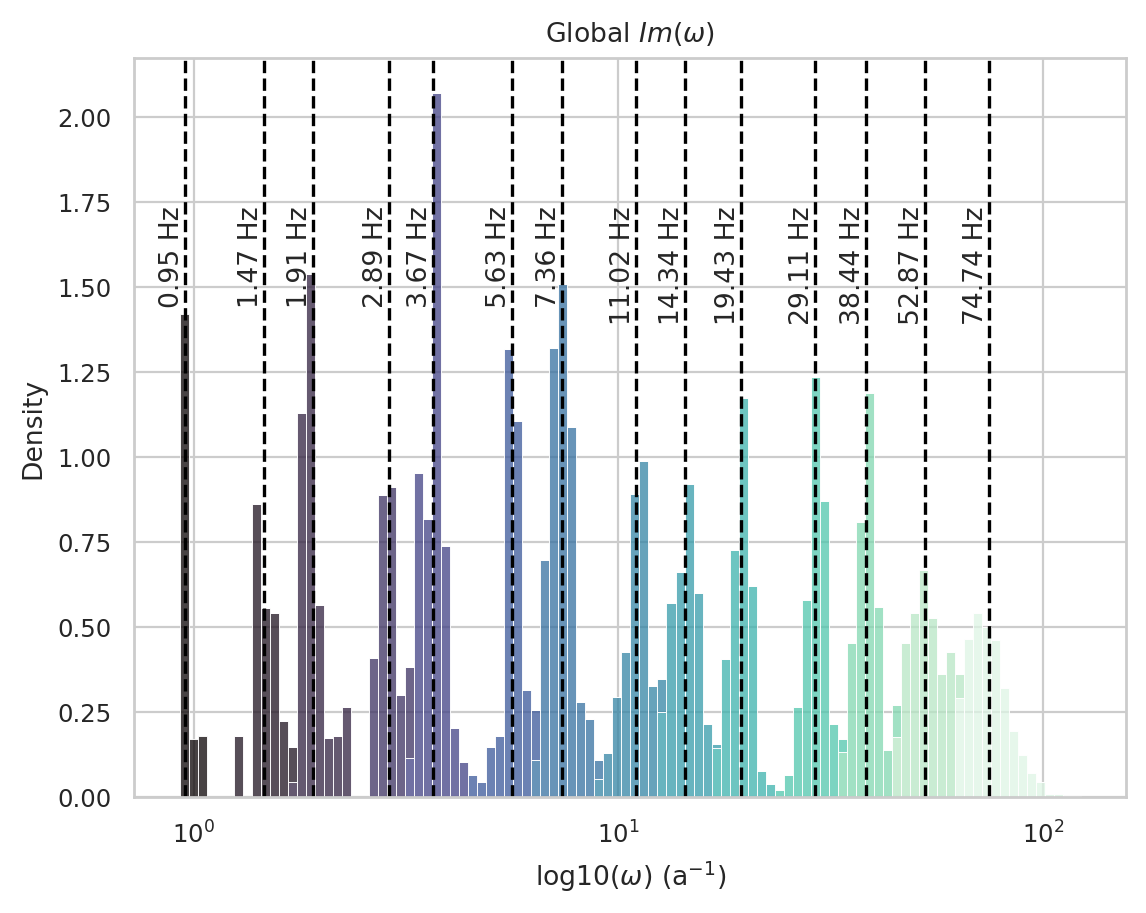

In [14]:
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)

# Convert the centroids to periods in units of seconds
cluster_centers = 10 ** (cluster_centroids) / (2 * np.pi)

sns.histplot(
    x=(10**omega_array) / (2 * np.pi),
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=100,
    palette="mako",
    legend=False,
    log_scale=True,
)

ax = plt.gca()
ax.set_title("Global $Im(\omega)$")
ax.set_xlabel(r"log10($\omega$) (a$^{-1}$)")
[ax.axvline(c, color="k", ls="--") for nc, c in enumerate(cluster_centers)]
y_lim_bottom, y_lim_top = ax.get_ylim()
[
    ax.text(
        c,
        y_lim_top - y_lim_top * 0.2,
        "{:4.2f} Hz".format(c),
        rotation="vertical",
        va="top",
        ha="right",
    )
    for c in cluster_centers
];

# Prepare for analysis

## Reconstruction

In [15]:
xr_sep = mrc.global_scale_reconstruction()
xr_background = mrc.get_background()
xr_global = xr_sep.sum(axis=(0, 1)) + xr_background

x = ds_obs_qc.x.values
y = ds_obs_qc.y.values

# Helper Functions

## Xarray dataset constructor

In [16]:
def mrcosts_reconstruction_to_xarray(
    xr_sep, xr_background, mrc, x_label, x_values, time_units, time, data_units
):
    ds_xr_sep = xr.DataArray(
        xr_sep.real,
        dims=["decomp_level", "cluster", x_label, "time"],
        coords=[
            np.arange(len(mrc.costs_array)),
            np.arange(mrc.n_components_global),
            x_values,
            time,
        ],
    )
    ds_cluster_centers = xr.DataArray(
        1 / (10 ** (mrc.cluster_centroids) / (2 * np.pi)),
        dims=["cluster"],
        coords=[np.arange(mrc.n_components_global)],
    )
    ds_cluster_centers.attrs["units"] = time_units
    ds_cluster_centers.attrs["long_name"] = "Central period of each period band"

    ds_global_separation = ds_xr_sep.to_dataset(name="frequency_bands")
    ds_global_separation["frequency_bands"].attrs["units"] = data_units
    ds_global_separation["frequency_bands"].attrs[
        "long_name"
    ] = "mrCOSTS band reconstruction"

    ds_global_separation.coords["cluster_centers"] = ds_cluster_centers

    ds_global_separation["background"] = ((x_label, "time"), xr_background)

    return ds_global_separation

## Convert reconstructions to xarray

This step converst the observations to be in the shape (`time` by `x` by `y`) instead of (`time` by `electrode`)

In [17]:
ds_obs_xy = ds_obs.set_index(electrode=("x", "y")).unstack("electrode")
ds_obs_xy

<xarray.Dataset>
Dimensions:     (time: 3839, x: 10, y: 10, event_time: 7)
Coordinates:
  * time        (time) float64 -0.0003 0.0007 0.0017 ... 3.836 3.837 3.838
  * event_time  (event_time) float64 0.25 0.6513 1.054 1.357 2.36 2.561 3.339
  * x           (x) float64 0.0 0.4 0.8 1.2 1.6 2.0 2.4 2.8 3.2 3.6
  * y           (y) float64 0.0 0.4 0.8 1.2 1.6 2.0 2.4 2.8 3.2 3.6
Data variables:
    signal      (time, x, y) float32 26.81 -45.11 -75.34 ... nan nan -118.3
    qc_mask     (x, y) object True False False False ... False nan nan False
    events      (event_time) object 'TS-ON' 'WS-ON' 'CUE-ON' ... 'SR' 'RW-ON'

In [18]:
ds_global_separation = mrcosts_reconstruction_to_xarray(
    xr_sep,
    xr_background,
    mrc,
    "electrode",
    ds_obs_qc.electrode,
    "s",
    ds_obs_qc.time,
    ds_obs_qc.signal.attrs["units"],
)

ds_global_separation.coords["x"] = ("electrode", x)
ds_global_separation.coords["y"] = ("electrode", y)

ds_global_separation_xy = ds_global_separation.frequency_bands.set_index(
    electrode=("x", "y")
).unstack("electrode")
ds_global_separation

<xarray.Dataset>
Dimensions:          (decomp_level: 6, cluster: 14, electrode: 89, time: 3839)
Coordinates:
  * decomp_level     (decomp_level) int64 0 1 2 3 4 5
  * cluster          (cluster) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * electrode        (electrode) int64 1 3 5 6 7 8 9 10 ... 90 91 92 93 94 95 96
  * time             (time) float64 -0.0003 0.0007 0.0017 ... 3.836 3.837 3.838
    cluster_centers  (cluster) float64 1.05 0.6821 0.5244 ... 0.01891 0.01338
    x                (electrode) float64 0.0 1.2 1.6 2.0 1.6 ... 2.8 2.8 3.6 3.2
    y                (electrode) float64 3.6 3.6 2.8 3.6 3.2 ... 0.0 0.4 0.4 0.0
Data variables:
    frequency_bands  (decomp_level, cluster, electrode, time) float64 0.0 ......
    background       (electrode, time) float64 36.97 36.92 ... -3.039 -3.014

In [19]:
ds_global_reconstruction = (
    ds_global_separation["frequency_bands"].sum(dim=["decomp_level", "cluster"])
    + ds_global_separation["background"]
)
ds_global_reconstruction.attrs["units"] = ds_obs.signal.attrs["units"]
ds_global_reconstruction.attrs["long_name"] = "LFP"

error = ds_global_reconstruction - ds_obs.signal
error.attrs["units"] = ds_obs.signal.attrs["units"]
error.attrs["long_name"] = "Error"

# Evaluations

## PSD

In [20]:
cl_slice_list_all = [slice(11, None), slice(8, 11), slice(3, 8), slice(0, 3)]
label_list_all = [
    r"> 30Hz $(\gamma)$",
    r"14-29Hz ($\beta$)",
    "3-11Hz (MRP)",
    "<3Hz (CNV)",
]

label_list_all_names = [
    r"$\gamma$",
    r"$\beta$",
    "MRP",
    "CNV",
]

In [21]:
omega_classes_as_bands = copy.deepcopy(omega_classes).astype(str)

for nslice, cl_slice in enumerate(cl_slice_list_all):

    start = cl_slice.start
    stop = cl_slice.stop
    if stop is None:
        stop = np.max(omega_classes) + 1
    omega_classes_as_bands[
        np.flatnonzero((omega_classes >= start) & (omega_classes < stop))
    ] = label_list_all_names[nslice]

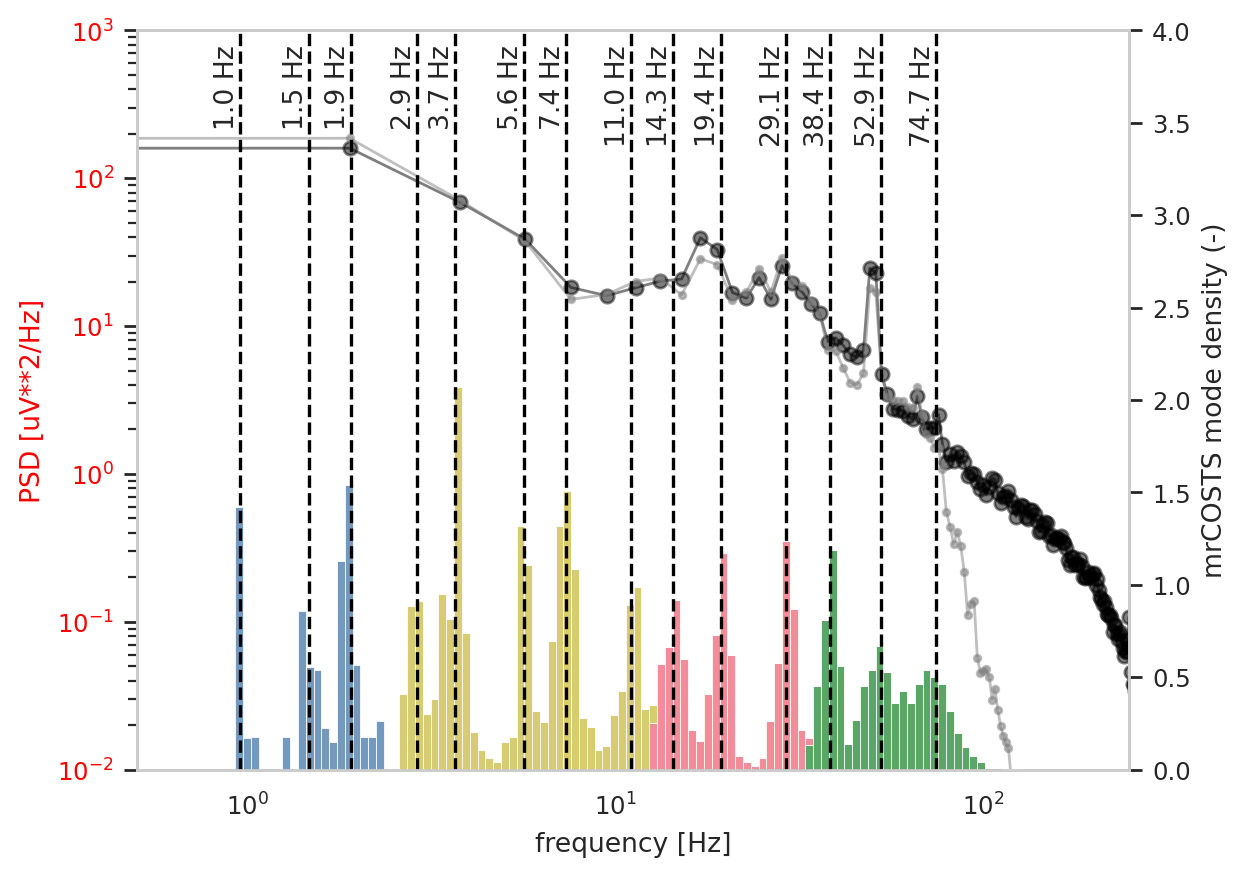

In [22]:
fs = 1 / dt
f, Pxx_den = signal.welch(data_to_fit.T, fs, nperseg=528, average="median")

fig, ax = plt.subplots(1, 1)
ax.loglog(f, np.mean(Pxx_den, axis=0), color="k", marker="o", lw=1, alpha=0.5, zorder=2)

f, Pxx_den = signal.welch(xr_global, fs, nperseg=528, average="median")
ax.loglog(
    f, np.mean(Pxx_den, axis=0), color="0.5", marker=".", lw=1, alpha=0.5, zorder=2
)

ax.set_ylim(10**-2, 10**3)
ax.set_xlim([0.5, 250])
ax.set_xlabel("frequency [Hz]")
ax.set_ylabel("PSD [uV**2/Hz]", color="r")
ax.tick_params(axis="y", labelcolor="r")
ax.grid(False)

# Use the interpolated omega for the clusters
ax2 = ax.twinx()

cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
    n_optimal, transform_method="log10"
)
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
cluster_centers = (10**cluster_centroids) / (2 * np.pi)

# Make a continuous color palette with the brightest and darkest exluded
palette = sns.color_palette("mako", len(cluster_centers) + 2)
palette = palette[1:-1]

sns.histplot(
    x=(10**omega_array) / (2 * np.pi),
    hue=omega_classes_as_bands,
    hue_order=label_list_all_names[::-1],
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=100,
    legend=False,
    ax=ax2,
)
ax2.set_ylabel("mrCOSTS mode density (-)")
ax2.set_ylim(0, 4)

[ax2.axvline(c, color="k", ls="--") for nc, c in enumerate(cluster_centers)]
y_lim_bottom, y_lim_top = ax.get_ylim()
[
    ax.text(
        c,
        y_lim_top - y_lim_top * 0.2,
        "{:0.1f} Hz".format(c),
        rotation="vertical",
        va="top",
        ha="right",
    )
    for c in cluster_centers
]
plt.grid(False)

## Compare reconstruction to obs

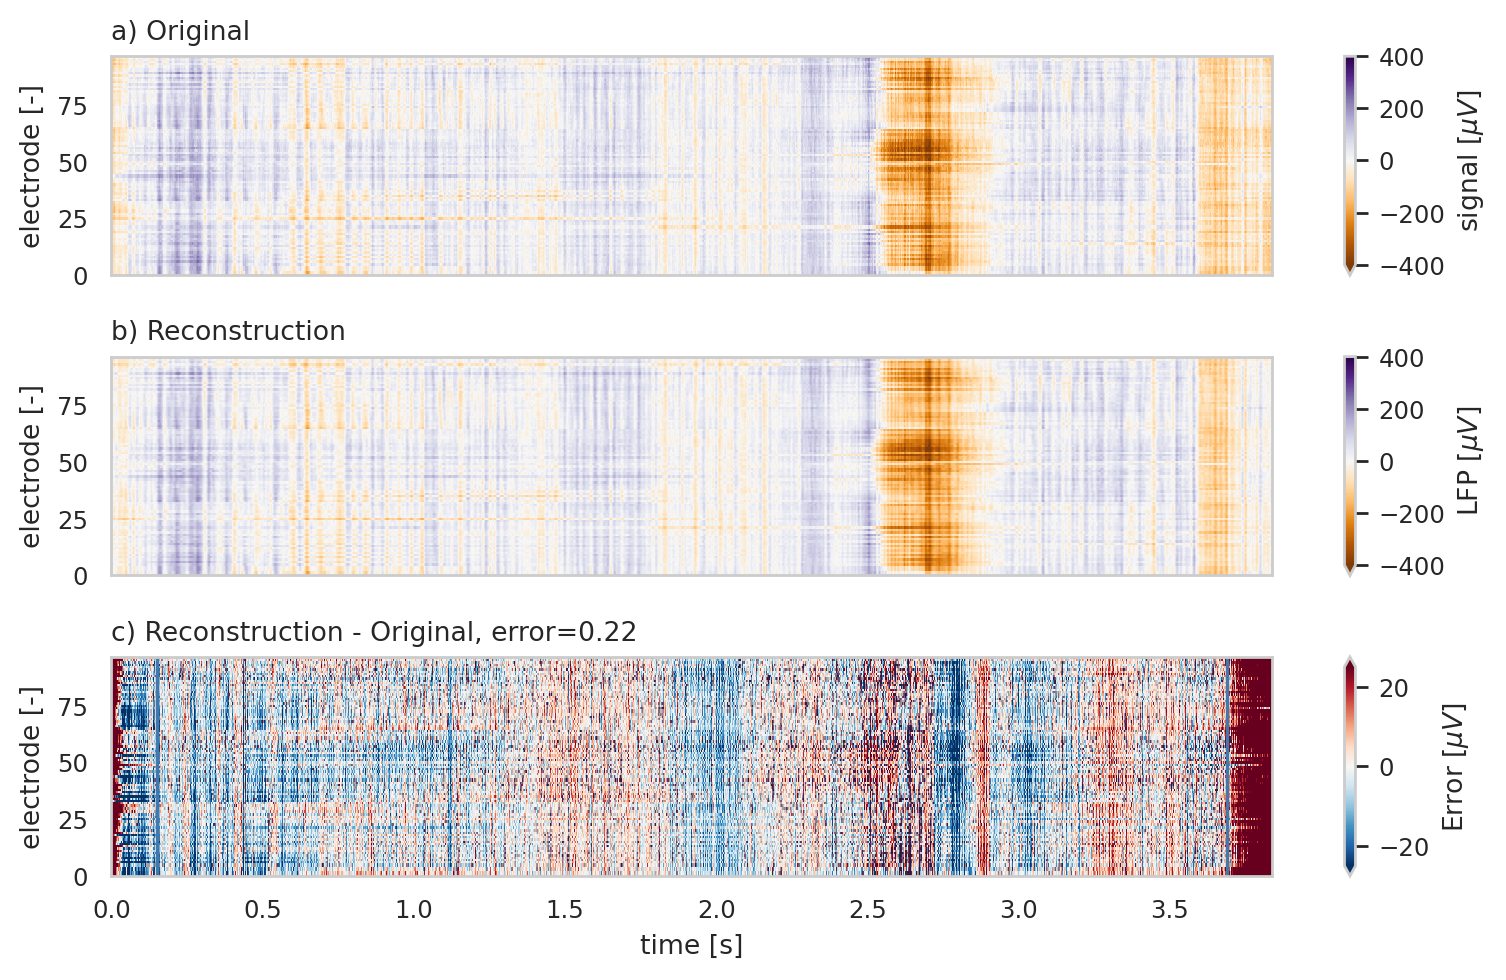

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(8, 5), sharex=True, sharey=True)

ax = axes[0]
ds_obs_qc.signal.T.plot(ax=ax, vmin=-400, vmax=400, cmap="PuOr")
ax.set_title("a) Original", loc="left")
ax.set_xlabel("")

ax = axes[1]
ds_global_reconstruction.plot(ax=ax, vmin=-400, vmax=400, cmap="PuOr")
ax.set_title("b) Reconstruction", loc="left")
ax.set_xlabel("")

ax = axes[2]
error.plot(ax=ax, vmin=-25, vmax=25, cmap="RdBu_r")
relative_error = mrc.costs_array[0].relative_error(xr_global, data_to_fit.T)
ax.set_title(f"c) Reconstruction - Original, error={relative_error:.2f}", loc="left")
ax.axvline(ts[150])
ax.axvline(ts[-150])
fig.tight_layout()

In [24]:
relative_error = mrc.costs_array[0].relative_error(xr_global, data_to_fit.T)
print(f"Error for all data = {relative_error:.2f}")

relative_error = mrc.costs_array[0].relative_error(
    xr_global[:, 150:-150], data_to_fit.T[:, 150:-150]
)
print(f"Error excluding first and last 0.15s of data = {relative_error:.2f}")

Error for all data = 0.22
Error excluding first and last 0.15s of data = 0.15


There was a slight change in the mrCOSTS code that explains the discrepancy between the error reported in the PNAS manuscript and what is shown here. This slight change would normally make the fit better but makes the old fits (used to make the notebook) worse.

## Specify plotting bands

These correspond to the neurological frequency bands specified and described in the PNAS manuscript.

In [25]:
cl_slice_list_all = [slice(11, None), slice(8, 11), slice(3, 8), slice(0, 3)]
label_list_all = [
    r"> 30Hz $(\gamma)$",
    r"14-29Hz ($\beta$)",
    "3-11Hz (MRP)",
    "<3Hz (CNV)",
]

label_list_all_names = [
    r"$\gamma$",
    r"$\beta$",
    "MRP",
    "CNV",
]


cl_slice_list = cl_slice_list_all[-2:][::-1]
label_list = label_list_all_names[-2:][::-1]

## Determine times to plot

In [26]:
go_event = ds_obs.events.isel(event_time=4)
go_time = go_event.event_time.values

start_move_event = ds_obs.events.isel(event_time=5)
start_move_time = start_move_event.event_time.values

start_end_times = [go_time, start_move_time]
times_to_plot = np.linspace(
    start=start_end_times[0], stop=start_end_times[1], num=5, endpoint=True
)

Visualize when these events are in the overall time series.

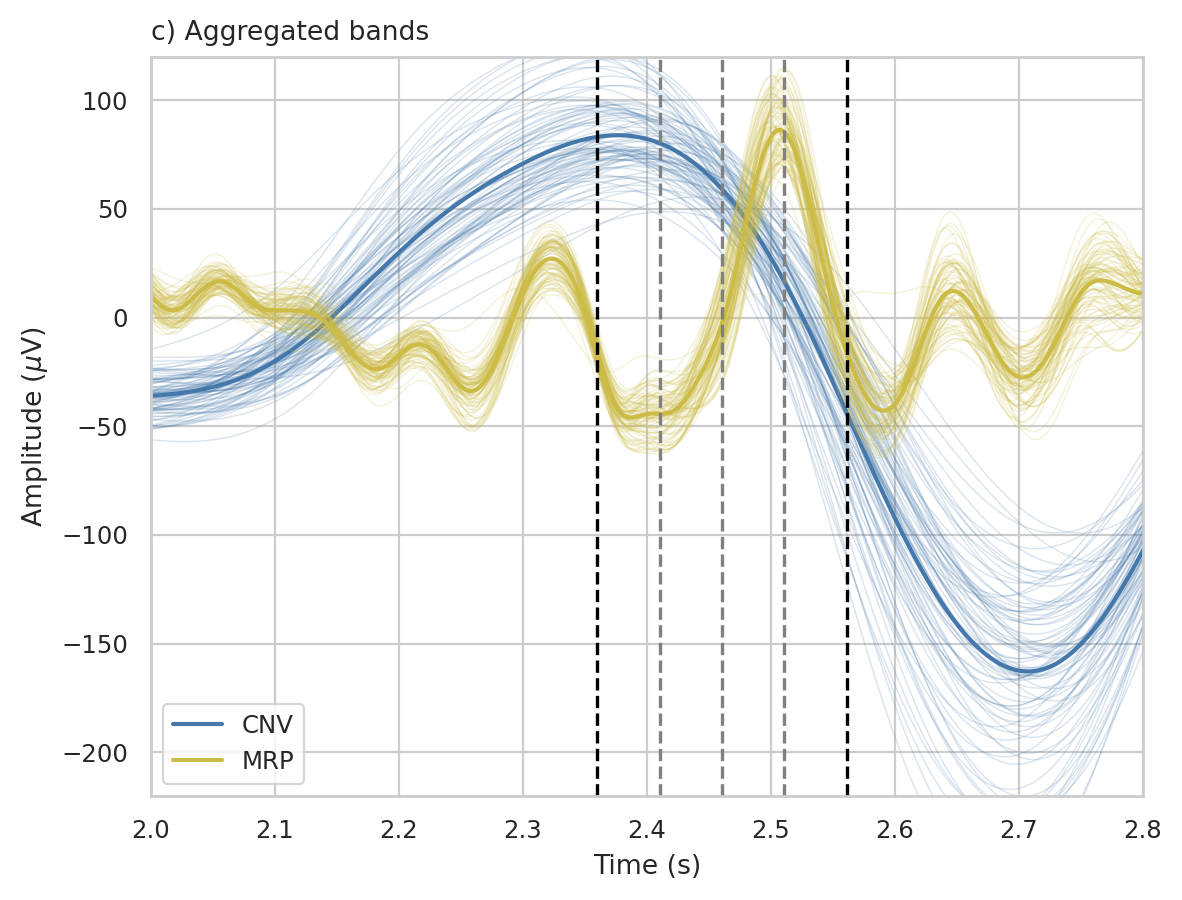

In [27]:
# Time series of components
fig, ax = plt.subplots(1, 1)
for nslice, cl_slice in enumerate(cl_slice_list):
    ds_plot = ds_global_separation.frequency_bands.isel(cluster=cl_slice).sum(
        dim=["cluster", "decomp_level"]
    )
    for n in ds_plot.electrode:
        ax.plot(
            ds_plot.time,
            ds_plot.sel(electrode=n).values,
            color=tol_bright_reorder[nslice],
            alpha=0.2,
            lw=0.5,
        )
    ax.plot(
        ds_plot.time,
        ds_plot.mean(dim="electrode"),
        lw=1.5,
        color=tol_bright_reorder[nslice],
        label=label_list[nslice],
    )
ax.set_ylabel("Amplitude ($\mu$V)")
ax.set_xlabel("Time (s)")
ax.set_title("c) Aggregated bands", loc="left")
ax.legend(loc="lower left")
ax.set_ylim(-220, 120)
ax.set_xlim(2.0, 2.8)
for t in times_to_plot:
    if t in start_end_times:
        color = "k"
    else:
        color = "0.5"
    ax.axvline(t, color=color, ls="--")

# PNAS Figure

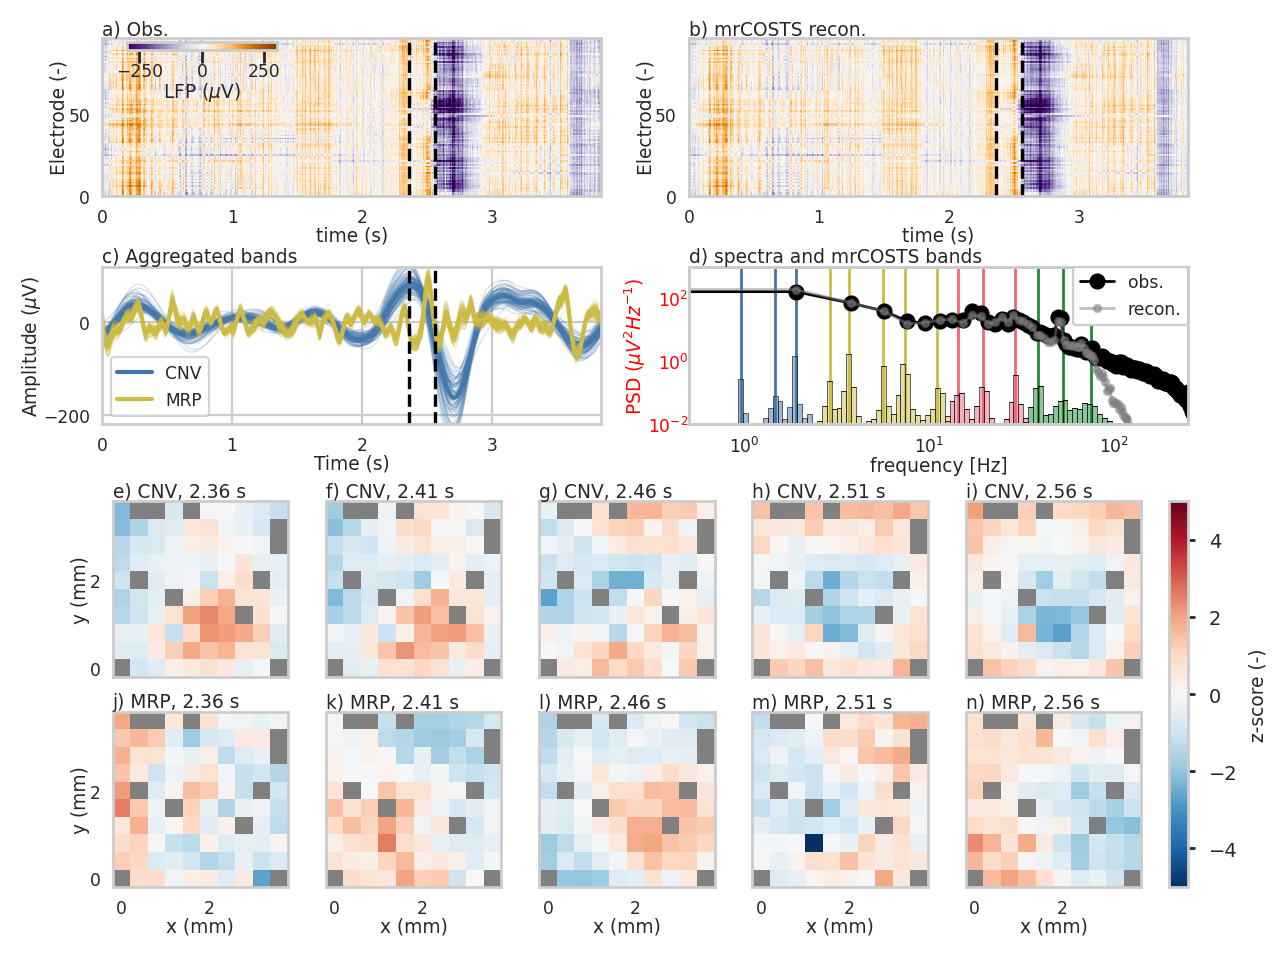

In [28]:
temp_context = {
    "xtick.major.pad": "-0.5",
    "ytick.major.pad": "-0.5",
}
with (
    sns.axes_style("whitegrid"),
    sns.plotting_context("paper", font_scale=0.7),
    sns.color_palette(sns.color_palette(tol_bright_reorder)),
    plt.rc_context(temp_context),
):

    # Construct the figure skeleton
    cm = 1 / 2.54  # centimeters in inches
    fig = plt.figure(figsize=(17.8 * cm, 14 * cm))

    gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 1], hspace=0.2)
    gs_top = gs[0].subgridspec(2, 2, wspace=0.175, hspace=0.45)
    # gs_mid = gs[1].subgridspec(1, 2, wspace=0.25, hspace=0.2)

    nrows = 2
    ncols = 5
    gs_bot = gs[1].subgridspec(
        nrows, ncols + 1, wspace=0.1, hspace=0.2, width_ratios=[1, 1, 1, 1, 1, 0.1]
    )

    axes_obs = fig.add_subplot(gs_top[0, 0])
    axes_recon = fig.add_subplot(gs_top[0, 1])

    axes_ts = fig.add_subplot(gs_top[1, 0])
    axes_specra = fig.add_subplot(gs_top[1, 1])

    axes_bands = []
    for nrow in range(nrows):
        for ncol in range(ncols):
            if len(axes_bands) > 0:
                axes_bands.append(
                    fig.add_subplot(
                        gs_bot[nrow, ncol],
                        sharex=axes_bands[0],
                        sharey=axes_bands[0],
                        aspect="equal",
                    )
                )
            else:
                axes_bands.append(fig.add_subplot(gs_bot[ncol], aspect="equal"))
    axes_colorbar = fig.add_subplot(gs_bot[:, -1])

    # Shared parameters
    vmin_global = -300
    vmax_global = 300
    pad = 1.5
    labelpad = 0
    cmap_global = matplotlib.cm.PuOr_r

    # --------------------------------------------------------------------------------
    # Observation time-space plot
    ax = axes_obs
    im = ax.pcolormesh(
        ds_obs_qc.time,
        ds_obs_qc.electrode,
        ds_obs_qc.signal.T,
        vmin=vmin_global,
        vmax=vmax_global,
        cmap=cmap_global,
        rasterized=True,
    )
    ax.set_title("a) Obs.", loc="left", pad=pad)
    ax.set_xlabel("time (s)", labelpad=labelpad)
    ax.set_ylabel("Electrode (-)", labelpad=labelpad)

    norm = matplotlib.colors.Normalize(vmin=vmin_global, vmax=vmax_global)
    cax = ax.inset_axes([0.05, 0.925, 0.3, 0.05])
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_global),
        cax=cax,
        orientation="horizontal",
    )
    cbar.set_label(f"LFP ($\mu$V)", labelpad=labelpad)
    for t in start_end_times:
        if t in start_end_times:
            color = "k"
        else:
            color = "0.5"
        ax.axvline(t, color=color, ls="--")

    # --------------------------------------------------------------------------------
    # mrCOSTS reconstruction time-space plot
    ax = axes_recon
    im = ax.pcolormesh(
        ds_global_reconstruction.time,
        ds_global_reconstruction.electrode,
        ds_global_reconstruction.values,
        vmin=-300,
        vmax=300,
        cmap=cmap_global,
        rasterized=True,
    )
    ax.set_title("b) mrCOSTS recon.", loc="left", pad=pad)
    ax.set_xlabel("time (s)", labelpad=labelpad)
    ax.set_ylabel("Electrode (-)", labelpad=labelpad)

    for t in start_end_times:
        if t in start_end_times:
            color = "k"
        else:
            color = "0.5"
        ax.axvline(t, color=color, ls="--")

    # --------------------------------------------------------------------------------
    # Time series of components
    ax = axes_ts
    for nslice, cl_slice in enumerate(cl_slice_list):
        ds_plot = ds_global_separation.frequency_bands.isel(cluster=cl_slice).sum(
            dim=["cluster", "decomp_level"]
        )
        for n in ds_plot.electrode:
            ax.plot(
                ds_plot.time,
                ds_plot.sel(electrode=n).values,
                color=tol_bright_reorder[nslice],
                alpha=0.2,
                lw=0.5,
            )
        ax.plot(
            ds_plot.time,
            ds_plot.mean(dim="electrode"),
            lw=1.5,
            color=tol_bright_reorder[nslice],
            label=label_list[nslice],
        )
    ax.set_ylabel("Amplitude ($\mu$V)", labelpad=labelpad)
    ax.set_xlabel("Time (s)", labelpad=labelpad)
    ax.set_title("c) Aggregated bands", loc="left", pad=pad)
    ax.legend(loc="lower left")
    ax.set_ylim(-220, 120)
    ax.set_xlim(0, ds_plot.time[-1])
    for t in start_end_times:
        if t in start_end_times:
            color = "k"
        else:
            color = "0.5"
        ax.axvline(t, color=color, ls="--")

    # --------------------------------------------------------------------------------
    # Use the interpolated omega for the clusters
    ax = axes_specra
    ax2 = ax.twinx()

    # Set the z-order of the axes directly.
    ax.set_zorder(2)
    ax2.set_zorder(1)
    # Make the PSD axis background invisible so ax2 is visible
    ax.patch.set_visible(False)

    cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
        n_optimal, transform_method="log10"
    )
    hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
    cluster_centers = (10**cluster_centroids) / (2 * np.pi)

    # Make a continuous color palette with the brightest and darkest exluded
    palette = sns.color_palette("mako", len(cluster_centers) + 2)
    palette = palette[1:-1]

    sns.histplot(
        x=(10**omega_array) / (2 * np.pi),
        hue_order=label_list_all_names[::-1],
        hue=omega_classes_as_bands,
        common_bins=True,
        common_norm=True,
        stat="density",
        multiple="stack",
        bins=80,
        palette=tol_bright_reorder,
        legend=False,
        ax=ax2,
        edgecolor="k",
        alpha=0.5,
        log_scale=True,
    )
    ax2.set_ylabel("")
    ax2.set_yticks([])
    ax2.set_yticklabels("")
    ax2.set_ylim(0, 4)

    for nc, c in enumerate(cluster_centers):
        if c in cluster_centers[cl_slice_list_all[::-1][0]]:
            color = tol_bright_reorder[0]
        elif c in cluster_centers[cl_slice_list_all[::-1][1]]:
            color = tol_bright_reorder[1]
        elif c in cluster_centers[cl_slice_list_all[::-1][2]]:
            color = tol_bright_reorder[2]
        elif c in cluster_centers[cl_slice_list_all[::-1][3]]:
            color = tol_bright_reorder[3]
        ax2.axvline(c, color=color, lw=1, zorder=0)

    plt.grid(False)
    ax.set_title("d) spectra and mrCOSTS bands", loc="left", pad=pad)

    # --------------------------------------------------------------------------------
    # Spectra

    fs = 1 / dt

    # Observations
    f, Pxx_den = signal.welch(data_to_fit.T, fs, nperseg=528, average="median")
    ax.loglog(
        f, np.mean(Pxx_den, axis=0), color="k", marker="o", lw=1, zorder=2, label="obs."
    )

    # Fit
    f, Pxx_den = signal.welch(xr_global, fs, nperseg=528, average="median")
    ax.loglog(
        f,
        np.mean(Pxx_den, axis=0),
        color="0.5",
        marker=".",
        lw=1,
        alpha=0.5,
        zorder=2,
        label="recon.",
    )

    ax.legend(loc="upper right", bbox_to_anchor=(1, 1), borderaxespad=0, framealpha=1)
    ax.set_ylim(10**-2, 10**3)
    ax.set_xlim([0.5, 250])
    ax.set_xlabel("frequency [Hz]", labelpad=labelpad)
    ax.set_ylabel(r"PSD ($\mu V^{2} Hz^{-1}$)", color="r", labelpad=labelpad)
    ax.tick_params(axis="y", labelcolor="r", width=0.5, length=0.5)
    ax.grid(False)

    # ----------------------------------------------------------------------------------------
    # Spatial plots of modes
    da_bands = ds_global_separation_xy.sum(dim="decomp_level", min_count=1)

    delta_t = 0.001
    vmax = 5
    vmin = -vmax

    for nt, t in enumerate(times_to_plot):
        for ncl_slice, cl_slice in enumerate(cl_slice_list):
            ds_cluster = da_bands.isel(cluster=cl_slice).sum(dim="cluster", min_count=1)

            event_band_means = ds_cluster.sel(
                time=slice(t - delta_t, t + delta_t)
            ).mean(dim="time")
            event_band_norm = (
                event_band_means - event_band_means.mean(dim=("x", "y"))
            ) / event_band_means.std(dim=("x", "y"))

            ax = axes_bands[nt + ncols * ncl_slice]
            im = ax.pcolormesh(
                event_band_norm.x,
                event_band_norm.y,
                event_band_norm.values.T,
                cmap="RdBu_r",
                vmin=vmin,
                vmax=vmax,
                rasterized=True,
            )
            ax.set_facecolor("0.5")
            ax.grid(False)
            ax.set_title(
                f"{alphabet[nt + ncols * ncl_slice + 4]}) {label_list[ncl_slice]}, {t:0.2f} s",
                loc="left",
                pad=pad,
            )
            if ax.axes.get_subplotspec().is_first_col():
                ax.set_ylabel("y (mm)", labelpad=labelpad)
            ax.set_xlabel("x (mm)", labelpad=labelpad)
            try:
                ax.label_outer()
            except:
                pass

    cmap = matplotlib.cm.RdBu_r
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=axes_colorbar,
        orientation="vertical",
    )
    cbar.set_label(f"z-score (-)")
    cbar.ax.tick_params(length=2.5, labelsize=7, pad=5)

    os.chdir(dir_print)
    fig.savefig("PNAS-neurology_overview.cue-to-move.png", dpi=300, bbox_inches="tight")
    fig.savefig("PNAS-neurology_overview.cue-to-move.pdf", bbox_inches="tight")